## Trabajo Práctico Número 3  - Logos de Coca-Cola



#### Consiga:

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en la carpeta ./images a partir del template ./template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos.
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo template del item 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [24]:
#importar librerías
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from imutils.object_detection import non_max_suppression

### Para mayor legibilidad del ejercicio, se implementarán las funciones como clases. 
##### Clase ImageData: encargada de cargar la imagen en un objeto.
##### Clase TemplateMatcher: contendrá los métodos para realizar la detección del template en la imagen, tanto detección única como múltiples detecciones.


In [25]:
class ImageData:
    """Clase para manejar la carga y procesamiento de imágenes.
    Atributos:
        name (str): Nombre del archivo de imagen.
        img (numpy.ndarray): Imagen original en formato BGR.
        rgb (numpy.ndarray): Imagen convertida a formato RGB.
        gray (numpy.ndarray): Imagen convertida a escala de grises.
        canny (numpy.ndarray): Imagen procesada con el detector de bordes Canny.
    """
    def __init__(self, path):
        self.name = os.path.basename(path)
        self.img = cv.imread(path)
        if self.img is None:
            raise ValueError(f'No se pudo cargar: {self.name}')
        self.rgb = cv.cvtColor(self.img, cv.COLOR_BGR2RGB)
        self.gray = cv.cvtColor(self.img, cv.COLOR_BGR2GRAY)
        self.canny = cv.Canny(self.gray, 100, 180, L2gradient=True)

In [76]:
class TemplateMatcher:
    """Clase para realizar la detección de un template en una imagen.
    Atributos:
        template (numpy.ndarray): Imagen del template en escala de grises.
        template_canny (numpy.ndarray): Imagen del template procesada con el detector de bordes Canny.
        method (int): Método de coincidencia de plantillas de OpenCV.
        scales (list): Lista de escalas para redimensionar la imagen durante la detección.
    """
    def __init__(self, template_path, canny_thresholds=(100, 150), method=cv.TM_CCORR_NORMED, scales=None):
        self.template = cv.imread(template_path, 0)
        self.template_canny = cv.Canny(self.template, *canny_thresholds, L2gradient=True)
        self.method = method
        self.scales = scales if scales is not None else [0.3, 0.65, 0.7500000000000002, 1, 1.5, 1.75, 2, 2.5, 4, 4.5]
    
    def detect_single(self, image, manual_scale=False, scale_range=(0.5, 4.5), scale_step=0.25):
        """Detecta una sola coincidencia del template en la imagen, con el mayor score
        Args:
            image (ImageData): Image data object containing rgb, gray, canny, and name.
            threshold (float): Minimum match score threshold.
            manual_scale (bool): If True, use scale_range and scale_step; otherwise, use predefined scales.
            scale_range (tuple): Range of scales for resizing (start, end).
            scale_step (float): Step size for scale range.
        
        Returns:
            tuple: (rectangle, score, scale) where rectangle is (x1, y1, x2, y2) or None if no detection.
        """
        if not manual_scale:
            scales = self.scales
        else:
            scales = np.arange(scale_range[0], scale_range[1], scale_step)
        
        w, h = self.template.shape[::-1]
        best_score, best_scale, best_loc, best_image_canny = -10, 0, None, None
        r = 1.0

        for s in scales:
            image_resized = cv.resize(image.gray, None, fx=s, fy=s, interpolation=cv.INTER_AREA)
            if image_resized.shape[0] > h and image_resized.shape[1] > w:
                image_canny = cv.Canny(image_resized, 100, 180, L2gradient=True)
                res = cv.matchTemplate(image_canny, self.template_canny, self.method)
                min_val, max_val, _, max_loc = cv.minMaxLoc(res)
                if max_val > best_score:
                    best_score = max_val
                    best_scale = s
                    r = image.gray.shape[1] / float(image_resized.shape[1])
                    best_loc = max_loc
                    best_image_canny = image_canny
        
        if best_loc is None:
            print(f"Imagen: {image.name}, No se detectó el template.")
            return None, best_score, best_scale
        
        top_left = (int(best_loc[0] * r), int(best_loc[1] * r))
        bottom_right = (int((best_loc[0] + w) * r), int((best_loc[1] + h) * r))
        rect = (top_left[0], top_left[1], bottom_right[0], bottom_right[1])

        return rect, best_score, best_scale, best_image_canny

    def detect_multiple(self, image, threshold=0.140, manual_scale=False, scale_range=(0.5, 3.0), scale_step=0.1):
        """Método para detectar múltiples coincidencias del template en la imagen.
        Args:
            image (ImageData): Objeto de datos de imagen que contiene rgb, gray, canny, and name.
            threshold (float): Umbral mínimo de puntuación de coincidencia.
            manual_scale (bool): Si es True, usa scale_range y scale_step; de lo contrario, usa escalas predefinidas.
            scale_range (tuple): Rango de escalas para redimensionar (inicio, fin).
            scale_step (float): Tamaño del paso para el rango de escalas.
        Returns:
            tuple: (rects, scores, best_score, best_scale) donde rects es una lista de rectángulos (x1, y1, x2, y2),
                    scores es una lista de puntuaciones de coincidencia, best_score es la mejor puntuación
                    y best_scale es la escala utilizada para la mejor coincidencia.
        """

        if not manual_scale:
            scales = self.scales
        else:
            scales = np.arange(scale_range[0], scale_range[1], scale_step)

        w, h = self.template.shape[::-1]
        rects, scores, best_score, best_scale = [], [], -10, 0
        best_res, r = None, 1.0

        for s in self.scales:
            image_resized = cv.resize(image.gray, None, fx=s, fy=s, interpolation=cv.INTER_AREA)
            if image_resized.shape[0] > h and image_resized.shape[1] > w:
                image_canny = cv.Canny(image_resized, 100, 180, L2gradient=True)
                res = cv.matchTemplate(image_canny, self.template_canny, self.method)
                min_val, max_val, _, _ = cv.minMaxLoc(res)
                if max_val > best_score:
                    best_scale = s
                    r = image.gray.shape[1] / float(image_resized.shape[1])
                    best_score = max_val
                    best_res = res
        
        if best_res is not None:
            loc = np.where(best_res >= threshold)
            for pt in zip(*loc[::-1]):
                rects.append((int(pt[0] * r), int(pt[1] * r), int((pt[0] + w) * r), int((pt[1] + h) * r)))
                scores.append(best_res[pt[1], pt[0]])
        
        rects = np.array(rects)
        if len(rects) > 0:
            rects = non_max_suppression(rects, probs=scores, overlapThresh=0.3)
        
        return rects, scores, best_score, best_scale
    

    def visualize_single(self, image, rect, best_score, best_scale, image_canny):
        """Visualiza la detección del template en una imagen.
        Args:
            image (ImageData): Objeto de datos de imagen.
            rect (tuple): Rectángulo detectado (x1, y1, x2, y2) o None si no se detectó.
            best_score (float): Mejor puntuación de coincidencia.
            best_scale (float): Escala utilizada para la mejor coincidencia.
            image_canny (numpy.ndarray): Imagen procesada con el detector de bordes Canny
        """
        img_rgb_copy = image.rgb.copy()
        if rect is not None:
            cv.rectangle(img_rgb_copy, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 255), 3)
        
        print(f"Imagen: {image.name}")
        print(f"Máximo: {np.round(best_score, 3)}")
        print(f"Nivel de Confianza:  {np.round(1- best_score,3)}")
        print(f"Escala: {best_scale}")

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(self.template_canny, cmap='gray')
        plt.title('Template con bordes de Canny')
        plt.subplot(1, 3, 2)
        plt.imshow(image_canny if image_canny is not None else image.canny, cmap='gray')
        plt.title('Imágen con bordes de Canny')
        plt.subplot(1, 3, 3)
        plt.imshow(img_rgb_copy)
        plt.title(f"Nivel de confianza: {np.round(1 - best_score, 3)}")
        plt.savefig(f"output/ej1_{image.name}", dpi=300, bbox_inches='tight')
        plt.show()


    def visualize_multiple(self, image, rects, best_score, best_scale):
        """Visualiza múltiples detecciones en la imagen.
        Args:
            image (ImageData): Objeto de datos de imagen.
            rects (list): Lista de rectángulos detectados (x1, y1, x2, y2).
            best_score (float): Mejor puntuación de coincidencia.
            best_scale (float): Escala utilizada para la mejor coincidencia.
        """
        img_rgb_copy = image.rgb.copy()
        for (x1, y1, x2, y2) in rects:
            cv.rectangle(img_rgb_copy, (x1, y1), (x2, y2), (0, 255, 255), 3)
        plt.figure(figsize=(8, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb_copy)
        plt.title(f"Detecciones: {len(rects)}, Escala: {best_scale}, Score: {np.round(best_score, 3)}")
        plt.subplot(1, 2, 2)
        plt.imshow(self.template_canny, cmap='gray')
        plt.title('Template con bordes de Canny')
        plt.savefig(f"output/ej2_{image.name}", dpi=300, bbox_inches='tight')
        plt.show()

### Resolución de los puntos del Trabajo Práctico:

In [ ]:
# Cargar imágenes desde el directorio './images'
image_dir = './images'
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)]
images = [ImageData(os.path.join(image_dir, f)) for f in image_files]


In [ ]:
# Inicializar el matcher con el template
# Cargamos el template desde './template/pattern.png'
template_matcher = TemplateMatcher('./template/pattern.png')

### Ejercicio 1: Ejecutar el método *detect_single* para encontrar la máxima coincidencia entre el template y la imagen, luego visualizarla con *visualize_single*

Imagen: COCA-COLA-LOGO.jpg
Máximo: 0.147
Nivel de Confianza:  0.853
Escala: 0.3


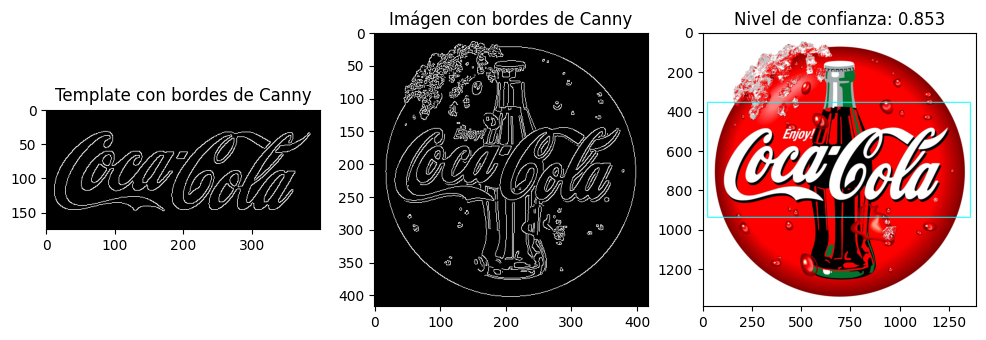

Imagen: coca_multi.png
Máximo: 0.181
Nivel de Confianza:  0.819
Escala: 4


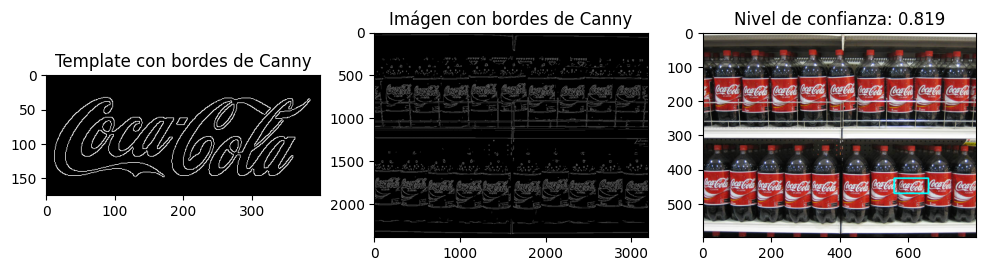

Imagen: coca_logo_1.png
Máximo: 0.181
Nivel de Confianza:  0.819
Escala: 2.5


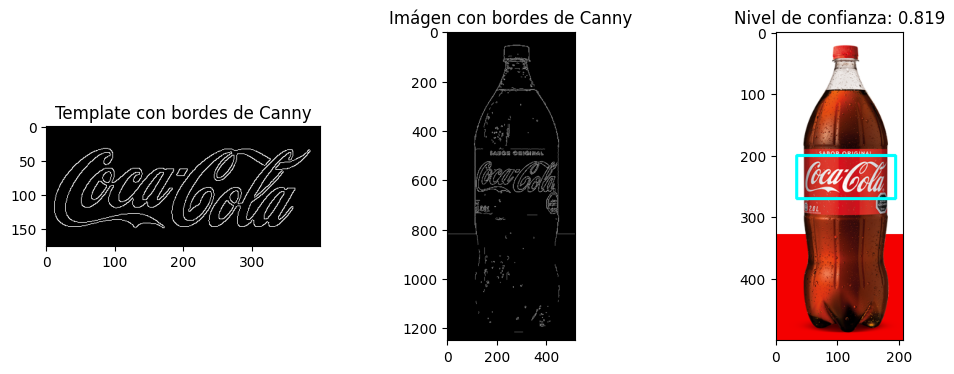

Imagen: coca_retro_1.png
Máximo: 0.181
Nivel de Confianza:  0.819
Escala: 0.7500000000000002


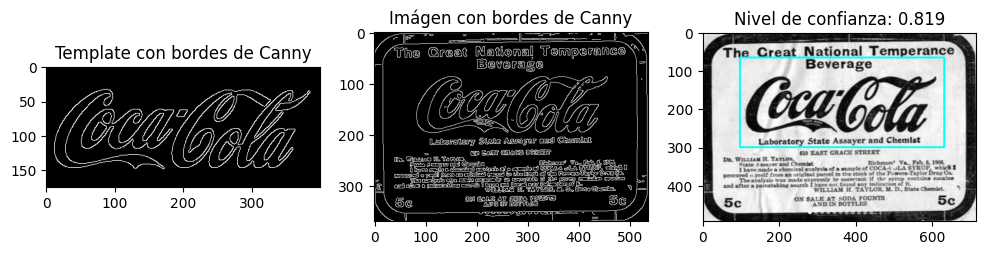

Imagen: logo_1.png
Máximo: 0.143
Nivel de Confianza:  0.857
Escala: 1.5


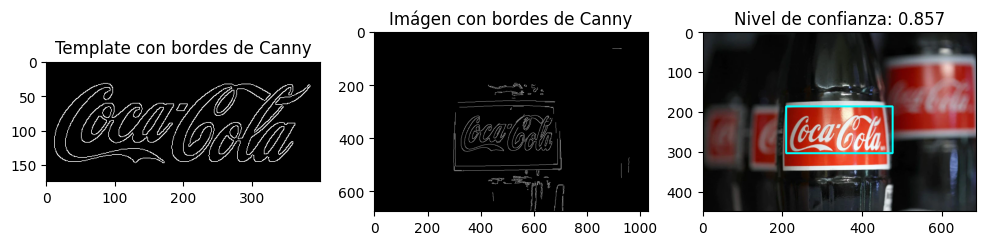

Imagen: coca_logo_2.png
Máximo: 0.136
Nivel de Confianza:  0.864
Escala: 1.75


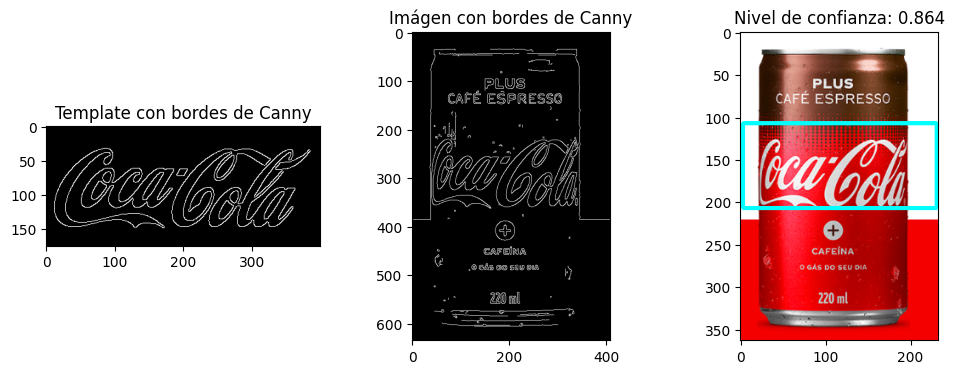

Imagen: coca_retro_2.png
Máximo: 0.224
Nivel de Confianza:  0.776
Escala: 2.5


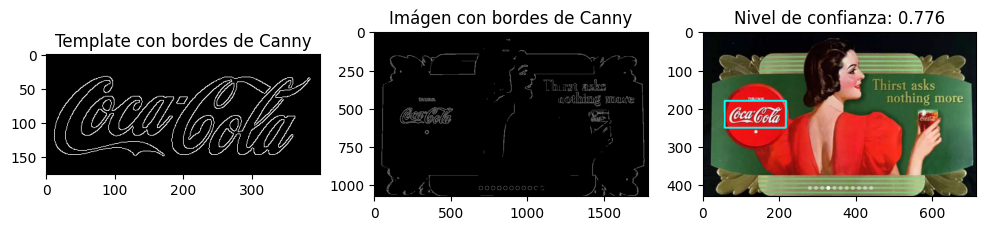

In [ ]:
# Bucle para procesar cada imagen detectando el template
for image in images:
    rect, best_score, best_scale, image_canny = template_matcher.detect_single(image)
    template_matcher.visualize_single(image, rect, best_score, best_scale, image_canny)


Mediante el empleo de Canny para extracción de bordes y tanto en el template como en las imágenes, se observa una correcta detección del template en todas las imágenes.
El haber incluido la opción de un rango dinámico de escalamiento de imágenes permitió acotar el rango de escala a emplear y así reducir la ejecución en este dataset, pero ser lo suficientemente genérico en caso de incorporar nuevas imágenes.

Se realizaron pruebas escalando el template pero los resultados no fueron satisfactorios en las detecciones, en particular al comparar con la implementación que escala a la imagen. 



### Ejercicio 2) Se emplea el método *detect_multiple* para encontar todas las coincidencias del template que superen el umbral definido en la variable *threshold* en la imagen coca_multi.png

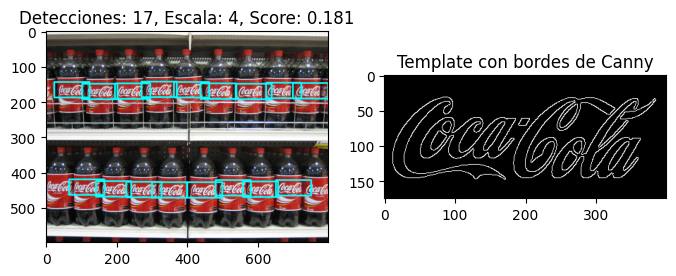

In [84]:
# Cargamos ./images/coca_multi.png para detección múltiple
image_coca_multiple = ImageData('./images/coca_multi.png')
# detectamos múltiples coincidencias:

rects, scores, best_score, best_scale = template_matcher.detect_multiple(image_coca_multiple, threshold=0.1355)
template_matcher.visualize_multiple(image_coca_multiple, rects, best_score, best_scale)

Luego de ejecutar el método de detección múltiple, se observa una correcta identificación de todos los logos visibles menos dos en las esquinas de la fila inferior. Al reducir el valor del threshold el algoritmo ya introduce una cantidad significativa de falso positivos.
Se debió utilizar la supresión de no máximos mediante la librería *non_max_suppression* debido a la multiplicidad de recuadros dibujados en la imagen final.


### Ejercicio 3) Se emplea el método *detect_multiple* para encontar todas las coincidencias del template que superen el umbral definido en la variable *threshold* en todas las imágenes del dataset.

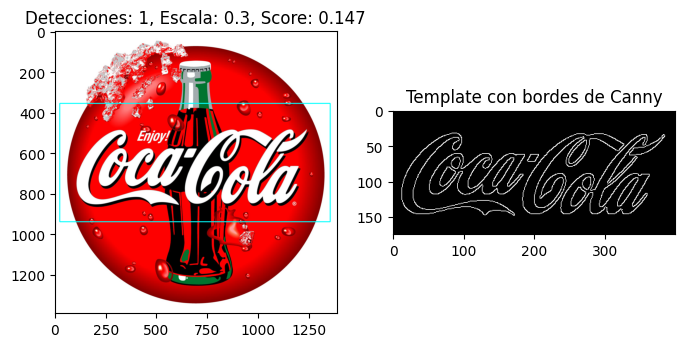

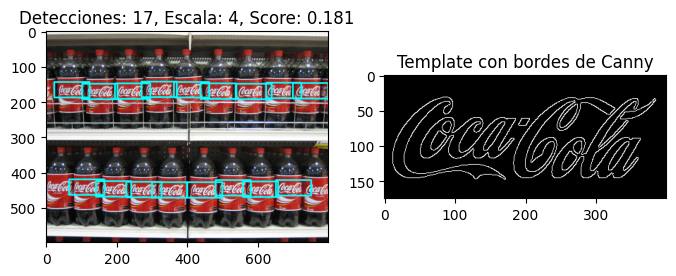

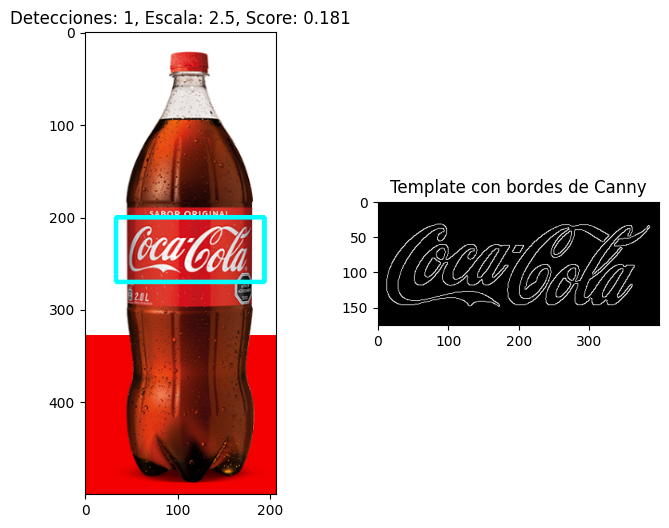

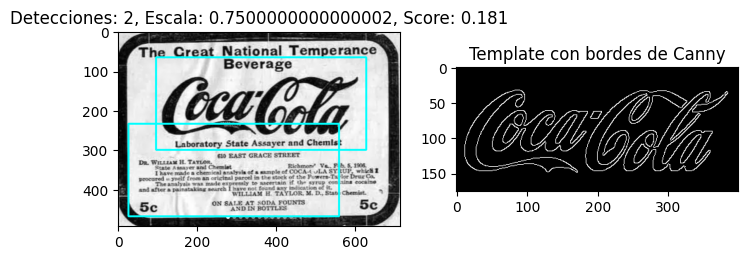

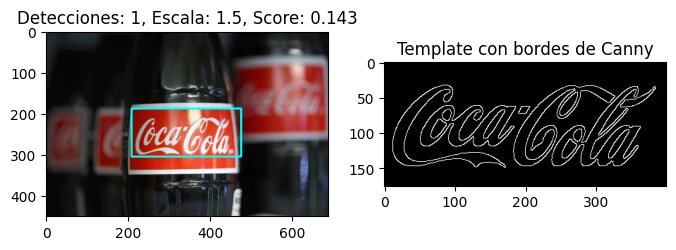

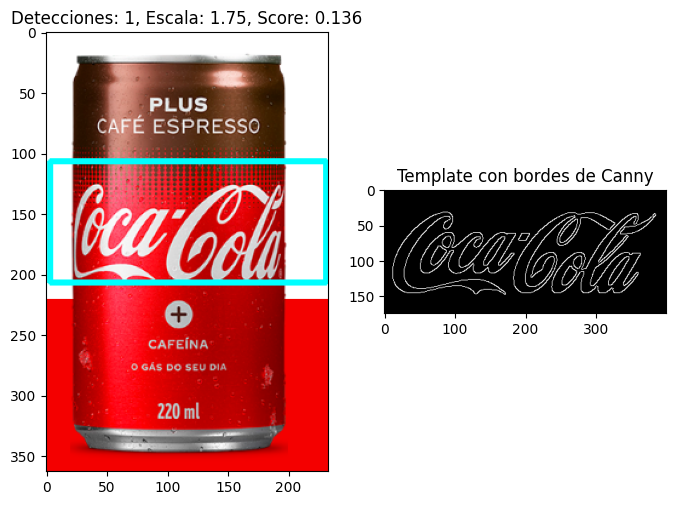

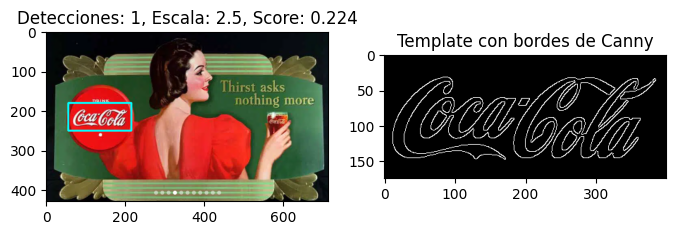

In [ ]:
# Bucle para procesar cada imagen detectando el template
for image in images:
    rects, scores, best_score, best_scale = template_matcher.detect_multiple(image, threshold=0.1355)
    template_matcher.visualize_multiple(image, rects, best_score, best_scale)

Se observa un comportamiento estable del método con buen reconocimiento del template en todas las imágenes y a excepción de la imagen "coca_retro_1.png" no se producen falsos positivos. El inconveniente que introdujo el usar un rango tan variado de imágenes resulta en no poder tener un valor de threshold común que no resulte en errores de detección. Cambiando los parámetros del template que solucionen a esta imagen introducen falsos en otras, por lo que optó por culminar el trabajo indicando ese error.